# Geospatial Indexing

- Creators: Rudy Klucik, Veronica Martinez, Charles Anderson and Carrie Wall
- Affiliations: Cooperative Institute for Research in Environmental Sciences ([CIRES](https://cires.colorado.edu/)) and National Oceanic and Atmospheric Admnistration (NOAA) National Centers for Environmental Information ([NCEI](https://www.ncei.noaa.gov/))
- Acknowledgements: Funding support was provided by the NOAA Center for Artificial Intelligence ([NCAI](https://www.noaa.gov/noaa-center-for-artificial-intelligence/)) and [NOAA Fisheries](https://www.fisheries.noaa.gov/)

## Overview
This notebook demonstrates a workflow to read timestamps from water column sonar data in Zarr format and convert that data to a GeoJSON format for mapping and GIS. The GeoJSON linestring will define the path of the ship as Sv data was recorded.

## Definitions
- Sv: water column sonar volume backscattering strength (Sv dB re 1 m-1)
- [NMEA](https://en.wikipedia.org/wiki/NMEA_0183): a data specification for communication between marine electronics including echo sounders, sonars, and GPS
- Datagram: the binary storage of data inside a file

## Prerequisites
To successfully navigate and use this notebook, you should be familiar with:

- the basics of Python programming such as loading modules, assigning variables, and list/array indexing
- plotting data
- Xarray

## Learning Outcomes
By working through this notebook, you will learn how to:

- access data from an S3 bucket
- use Xarray to read cloud-native Zarr formatted files
- extract navigation data from a Zarr store
- use GeoPandas to organize geospatial data into GeoJSON format
- plot geospatial data in a mapping interface

## Software
This tutorial uses the Python programming language and packages. We will use:

- Boto3 to access data from an S3 bucket
- Zarr to work with cloud native files
- Xarray to work with Zarr files and for data analysis
- Numpy for simple array operations
- Pandas for creating a dataframe
- GeoPandas for creating a geospatial dataframe
- [Folium](https://geopandas.org/en/stable/gallery/plotting_with_folium.html) to plot data





# Set up

Install and import required python packages.

In [ ]:
%%capture
!pip install boto3
!pip install xarray
!pip install zarr
!pip install s3fs
!pip install geopandas==0.13.1
!pip install folium

import s3fs
import folium
import os
import zarr
import boto3
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from botocore import UNSIGNED
from botocore.config import Config

import matplotlib.pyplot as plt

# Access data

Data is freely available from the NCEI archives and can be accessed from an AWS S3 bucket. Use boto3 to download a data file.

s3fs can be used to create a pythonic filesystem interface for S3 for easier navigation of the bucket.

In [ ]:
# Connect to S3 bucket. Use UNSIGNED to connect as an anonymous user
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [ ]:
# raw_file = "data/raw/Henry_B._Bigelow/HB0707/EK60/D20070712-T201647.raw"

In [ ]:
s3_file_system = s3fs.S3FileSystem(anon=True)

In [ ]:
bucket_name = 'noaa-wcsd-zarr-pds'
ship_name = 'Bell_M._Shimada'
cruise_name = 'SH1507'
sensor_name = 'EK60'
zarr_store = 'SH1507.zarr'
s3_zarr_store_path = f"{bucket_name}/level_2/{ship_name}/{cruise_name}/{sensor_name}/{zarr_store}"

In [ ]:
store = s3fs.S3Map(root=s3_zarr_store_path, s3=s3_file_system, check=False)

In [ ]:
cruise = xr.open_zarr(store=store, consolidated=None)
cruise

<xarray.Dataset>
Dimensions:    (depth: 2800, time: 3234, frequency: 5)
Coordinates:
  * depth      (depth) float64 nan 0.25 0.5 0.75 1.0 ... 699.2 699.5 699.8 700.0
  * frequency  (frequency) float32 1.8e+04 3.8e+04 7e+04 1.2e+05 2e+05
  * time       (time) datetime64[ns] 2015-07-19T19:08:39.063712768 ... 2015-0...
Data variables:
    Sv         (depth, time, frequency) float32 dask.array<chunksize=(512, 512, 1), meta=np.ndarray>
    latitude   (time) float32 dask.array<chunksize=(512,), meta=np.ndarray>
    longitude  (time) float32 dask.array<chunksize=(512,), meta=np.ndarray>
Attributes:
    processing_software_name:     echofish
    processing_software_version:  0.0.1
    processing_time:              2023-10-01T18:08:01Z

# Extract spatial and temporal data from the Zarr store
The GPS coordinates and time stamps can be accessed from the 'cruise'. The 'time' is a coordinate for the underlying data while 'latitude' and 'longitude' are data variables with the same dimension. Essentially, for every vertical measurement of water-column sonar data there is an associated timestamp, a latitude, and a longitude. Each variable can be accessed by name to the the Xarray DataArray, e.g. 'cruise.time', or via 'cruise.time.values' to the just the data.

The time DataArray values can be accessed by the coordinate name, 'time' as follows:

In [ ]:
cruise.time

<xarray.DataArray 'time' (time: 3234)>
array(['2015-07-19T19:08:39.063712768', '2015-07-19T19:08:40.360587776',
       '2015-07-19T19:08:41.641838080', ..., '2015-07-19T20:04:38.676898816',
       '2015-07-19T20:04:39.692524032', '2015-07-19T20:04:40.723773952'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-07-19T19:08:39.063712768 ... 2015-07-...
Attributes:
    long_name:      Timestamp of each ping
    standard_name:  time

The latitude DataArray values can be accessed by name as follows:

In [ ]:
cruise.latitude

<xarray.DataArray 'latitude' (time: 3234)>
dask.array<open_dataset-latitude, shape=(3234,), dtype=float32, chunksize=(512,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-07-19T19:08:39.063712768 ... 2015-07-...
Attributes:
    long_name:  Latitude
    units:      degrees_north

Longitude values similarly:

In [ ]:
cruise.longitude

<xarray.DataArray 'longitude' (time: 3234)>
dask.array<open_dataset-longitude, shape=(3234,), dtype=float32, chunksize=(512,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-07-19T19:08:39.063712768 ... 2015-07-...
Attributes:
    long_name:  Longitude
    units:      degrees_east

Write the gps_df linestring to geojson. GeoJSON is a format for encoding a variety of geographic data structures

## Creating a GeoPandas DataFrame

The latitude, longitude, and timestamps can be combined to create a GeoPandas dataframe as follows:

In [ ]:
# Start by creating a pandas dataframe containing lat, lon, and time for the cruise
gps_df = pd.DataFrame({'latitude': cruise.latitude.values, 'longitude': cruise.longitude.values, 'time': cruise.time.values}).set_index(['time'])

gps_df

,latitude,longitude
time,,
2015-07-19 19:08:39.063712768,41.784866,-124.543594
2015-07-19 19:08:40.360587776,41.784832,-124.543503
2015-07-19 19:08:41.641838080,41.784832,-124.543503
2015-07-19 19:08:42.923087872,41.784874,-124.543365
2015-07-19 19:08:44.204338176,41.784832,-124.543335
...,...,...
2015-07-19 20:04:36.630024192,41.749443,-124.524727
2015-07-19 20:04:37.661274112,41.749500,-124.524834
2015-07-19 20:04:38.676898816,41.749405,-124.524788


Create a GeoPandas FeatureCollection indexed by time (missing values are dropped). GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types.

In [ ]:
gps_gdf = gpd.GeoDataFrame(
    gps_df,
    geometry=gpd.points_from_xy(gps_df['longitude'], gps_df['latitude']),
    crs="epsg:4326"
).dropna()

gps_gdf

,latitude,longitude,geometry
time,,,
2015-07-19 19:08:39.063712768,41.784866,-124.543594,POINT (-124.54359 41.78487)
2015-07-19 19:08:40.360587776,41.784832,-124.543503,POINT (-124.54350 41.78483)
2015-07-19 19:08:41.641838080,41.784832,-124.543503,POINT (-124.54350 41.78483)
2015-07-19 19:08:42.923087872,41.784874,-124.543365,POINT (-124.54337 41.78487)
2015-07-19 19:08:44.204338176,41.784832,-124.543335,POINT (-124.54333 41.78483)
...,...,...,...
2015-07-19 20:04:36.630024192,41.749443,-124.524727,POINT (-124.52473 41.74944)
2015-07-19 20:04:37.661274112,41.749500,-124.524834,POINT (-124.52483 41.74950)
2015-07-19 20:04:38.676898816,41.749405,-124.524788,POINT (-124.52479 41.74940)


The GeoPandas dataframe can be converted to a GeoJSON format for serialization:

In [ ]:
geojson = gps_gdf.to_json()
geojson

'{"type": "FeatureCollection", "features": [{"id": "2015-07-19T19:08:39.063712768", "type": "Feature", "properties": {"latitude": 41.78486633300781, "longitude": -124.54359436035156}, "geometry": {"type": "Point", "coordinates": [-124.54359436035156, 41.78486633300781]}}, {"id": "2015-07-19T19:08:40.360587776", "type": "Feature", "properties": {"latitude": 41.78483200073242, "longitude": -124.54350280761719}, "geometry": {"type": "Point", "coordinates": [-124.54350280761719, 41.78483200073242]}}, {"id": "2015-07-19T19:08:41.641838080", "type": "Feature", "properties": {"latitude": 41.78483200073242, "longitude": -124.54350280761719}, "geometry": {"type": "Point", "coordinates": [-124.54350280761719, 41.78483200073242]}}, {"id": "2015-07-19T19:08:42.923087872", "type": "Feature", "properties": {"latitude": 41.784873962402344, "longitude": -124.54336547851562}, "geometry": {"type": "Point", "coordinates": [-124.54336547851562, 41.784873962402344]}}, {"id": "2015-07-19T19:08:44.204338176"

## Plotting the Trackline

Next we create a geospatial plot of the trackline using GeoPanda's built-in plotting function.

<Axes: >

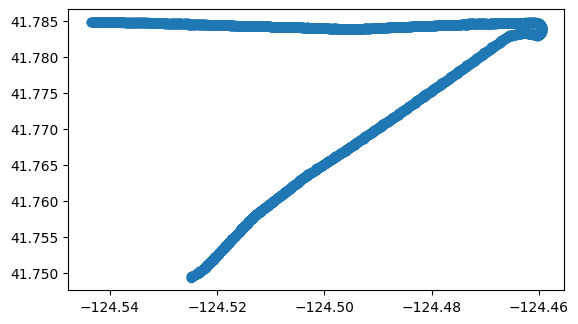

In [ ]:
gps_gdf.plot()

Note the uncertainty assoicated with GPS measurements as the ship moves along its path.

## Converting Points to a Simplified Linestring

Plotting the linestring as below with gps_gdf.explore().

In [ ]:
gps_gdf.index = gps_gdf.index.astype(str)

In [ ]:
%%capture
!pip install mapclassify
import mapclassify as mc

In [ ]:
gps_gdf.explore()

## Creating a GeoJSON Linestring

Combining all the latitude and longitude values we can create a geometry linestring.

In [ ]:
import shapely.geometry as geom

In [ ]:
linestring = geom.LineString( [xy for xy in zip(gps_gdf.latitude, gps_gdf.longitude)] )

In [ ]:
#linestring = geom.LineString(gps_gdf['geometry'])

In [ ]:
len(linestring.coords)

3234

In [ ]:
linestring.coords[0]

(41.78486633300781, -124.54359436035156)

## Simplification

The geometry contains a lot of points to specify the path of the ship's journey. This geometry can simplified using the [Ramer–Douglas–Peucker algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm). This algorithm finds a geometry that travels the same path and can do so when specified with a single tolerance value, here that value is set to "0.01."

In [ ]:
lineSimplified = linestring.simplify(tolerance=0.01, preserve_topology=True)

Note how the total number of coordinates needed to specify the linestring drops significantly based on the tolerance value.

In [ ]:
print(f"Total number of points for original linestring: {len(linestring.coords)}")

Total number of points for original linestring: 3234


In [ ]:
print(f"Total number of points needed for the simplified linestring: {len(lineSimplified.coords)}")

Total number of points needed for the simplified linestring: 3


In [ ]:
from IPython.display import display

## Plotting the data interactively

We can start by roughly calculating the centroid of the area of interest.

In [ ]:
centroid = gps_gdf.geometry.centroid

<ipython-input-27-85dae3be9dec>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gps_gdf.geometry.centroid


Next extract the coordinates of the centroid (latitude, longitude).

In [ ]:
center_latitude = centroid.y.iloc[0]
center_longitude = centroid.x.iloc[0]

And finally plot the simplified PolyLine of the ships movement throughout the duration of the cruise.

In [ ]:
m = folium.Map(location=[center_latitude, center_longitude], zoom_start=10)

folium.PolyLine(lineSimplified.coords).add_to(m)

In [ ]:
display(m)

# Data Statement
All data used in this notebook are publicly available

The Level 2 data can be found here:

*   https://noaa-wcsd-zarr-pds.s3.us-east-1.amazonaws.com/level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr/


The files can be explored by navigating to the following AWS file explorer:

*   https://noaa-wcsd-zarr-pds.s3.amazonaws.com/index.html#level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr/

# Metadata
- Language / packages(s):
 - Language: Python
 - Packages: Boto, Xarray, Zarr, Numpy, Pandas, GeoPandas

- Scientific domain:
 - Fisheries acoustics

- Application keywords:
 - Sonar processing

- Geophysical keywords
 - Spatial location

# License
## Software and Content Description License
Software code created by U.S. Government employees is not subject to copyright in the United States (17 U.S.C. §105). The United States/Department of Commerce reserve all rights to seek and obtain copyright protection in countries other than the United States for Software authored in its entirety by the Department of Commerce. To this end, the Department of Commerce hereby grants to Recipient a royalty-free, nonexclusive license to use, copy, and create derivative works of the Software outside of the United States.

# Disclaimer
This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA Jupyter notebooks are provided on an 'as is' basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.